A primeira etapa consiste em configurar o ambiente de trabalho. Isso inclui montar o Google Drive para acessar nossos arquivos e importar todas as bibliotecas Python que serão utilizadas ao longo do projeto, desde a manipulação de dados (pandas) até a modelagem (xgboost) e visualização (seaborn, matplotlib).

In [1]:

# Importando todas as bibliotecas necessárias para o projeto
import pandas as pd
import numpy as np
import os
import requests
import time
import pickle

# Bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Ferramentas de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Utilitários
from tqdm import tqdm
from google.colab import drive

# Montando o Google Drive
drive.mount('/content/drive')

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Mounted at /content/drive


#1. Carregamento de Dados (com Lógica de Cache)
Para tornar o processo mais eficiente, implementei uma lógica de cache. O notebook primeiro verifica se um arquivo de dados já enriquecido (imdb_enriquecido.csv) existe no Google Drive.

Se o arquivo existir, ele é carregado diretamente, poupando o tempo de processamento da API (mais de 4 minutos).

Se não existir (na primeira execução), o notebook carrega o arquivo original e se prepara para a etapa de enriquecimento de dados

In [2]:

# Define os caminhos para os arquivos no seu Google Drive
original_file_path = '/content/drive/MyDrive/lighthouse/desafio_indicium_imdb.csv'
enriched_file_path = '/content/drive/MyDrive/imdb_enriquecido.csv'

# Verifica se o arquivo de cache existe
if os.path.exists(enriched_file_path):
    print("Cache encontrado! Carregando dataset enriquecido localmente...")
    df = pd.read_csv(enriched_file_path)
    run_api_enrichment = False
else:
    print("Cache não encontrado. Carregando dataset original para enriquecimento via API...")
    try:
        df = pd.read_csv(original_file_path)
        run_api_enrichment = True
    except FileNotFoundError:
        print(f"ERRO: Arquivo original não encontrado em '{original_file_path}'")
        df = pd.DataFrame() # Cria um dataframe vazio para evitar erros
        run_api_enrichment = False

if not df.empty:
    print(f"\nDataset carregado com sucesso! Contém {df.shape[0]} linhas e {df.shape[1]} colunas.")
    display(df.head())

Cache encontrado! Carregando dataset enriquecido localmente...

Dataset carregado com sucesso! Contém 999 linhas e 18 colunas.


,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Budget,Revenue
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411",6000000.0,2.450664e+08
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444",185000000.0,1.004558e+09
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000",13000000.0,1.026000e+08
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000",397751.0,4.360000e+06
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905",94000000.0,1.118889e+09


#2. Enriquecimento de Dados via API TMDb
Com o dataset base carregado, o próximo passo é enriquecê-lo com dados financeiros que não estão presentes no arquivo original: Orçamento de Produção (Budget) e Faturamento Mundial (Revenue). Para isso, consultamos a API do The Movie Database (TMDb) para cada um dos filmes.

Esta etapa é executada apenas uma vez. Ao final, o DataFrame enriquecido é salvo como imdb_enriquecido.csv no Google Drive, criando o cache para as futuras execuções.

Nota de Segurança: A chave de API é carregada a partir do gerenciador de "Secrets" do Google Colab para garantir que não fique exposta no código.

In [3]:


if run_api_enrichment:
    print("Iniciando o processo de enriquecimento de dados via API do TMDb. Isso pode levar alguns minutos...")

    # --- Configuração da API ---
    # Lembre-se de usar o gerenciador de Secrets do Colab para proteger sua chave!
    from google.colab import userdata
    try:
        # Tenta pegar a chave do gerenciador de Secrets
        API_KEY = userdata.get('TMDB_API_KEY')
    except Exception as e:
        # Se não encontrar, use um placeholder (substitua ou adicione ao Secrets)
        API_KEY = 'SUA_CHAVE_API_AQUI'
        print("AVISO: Chave de API não encontrada no gerenciador de Secrets. Usando placeholder.")

    BASE_URL = 'https://api.themoviedb.org/3'

    def get_movie_details(title, year):
        """Busca um filme por título e ano, e retorna seu orçamento e faturamento."""
        search_url = f"{BASE_URL}/search/movie"
        search_params = {'api_key': API_KEY, 'query': title, 'primary_release_year': year}
        try:
            response = requests.get(search_url, params=search_params)
            data = response.json()
            if data.get('results'):
                movie_id = data['results'][0]['id']
                details_url = f"{BASE_URL}/movie/{movie_id}"
                details_params = {'api_key': API_KEY}
                details_response = requests.get(details_url, params=details_params)
                details_data = details_response.json()
                return {
                    'Budget': details_data.get('budget', None),
                    'Revenue': details_data.get('revenue', None)
                }
        except Exception as e:
            print(f"Erro ao buscar '{title}': {e}")
        return None

    # --- Loop para popular o DataFrame ---
    budgets = []
    revenues = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Buscando dados na API"):
        details = get_movie_details(row['Series_Title'], row['Released_Year'])
        if details:
            budgets.append(details['Budget'])
            revenues.append(details['Revenue'])
        else:
            budgets.append(None)
            revenues.append(None)
        time.sleep(0.1)

    # --- Adicionando e salvando as novas colunas ---
    df['Budget'] = budgets
    df['Revenue'] = revenues

    # Limpeza básica dos dados da API antes de salvar
    df['Budget'] = df['Budget'].replace(0, np.nan)
    df['Revenue'] = df['Revenue'].replace(0, np.nan)

    # Salva o arquivo enriquecido para criar o cache
    df.to_csv(enriched_file_path, index=False)
    print(f"\nEnriquecimento concluído! Dados salvos em '{enriched_file_path}' para uso futuro.")

else:
    print("Dados já estavam enriquecidos. Pulando etapa da API.")

Dados já estavam enriquecidos. Pulando etapa da API.


#3. Análise Exploratória de Dados (EDA) e Insights de Negócio
Agora, com um dataset completo em mãos, podemos explorá-lo para encontrar padrões e responder às perguntas de negócio da PProductions.

/tmp/ipython-input-4068278111.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=roi_by_genre.index, y=roi_by_genre.values, palette='magma')


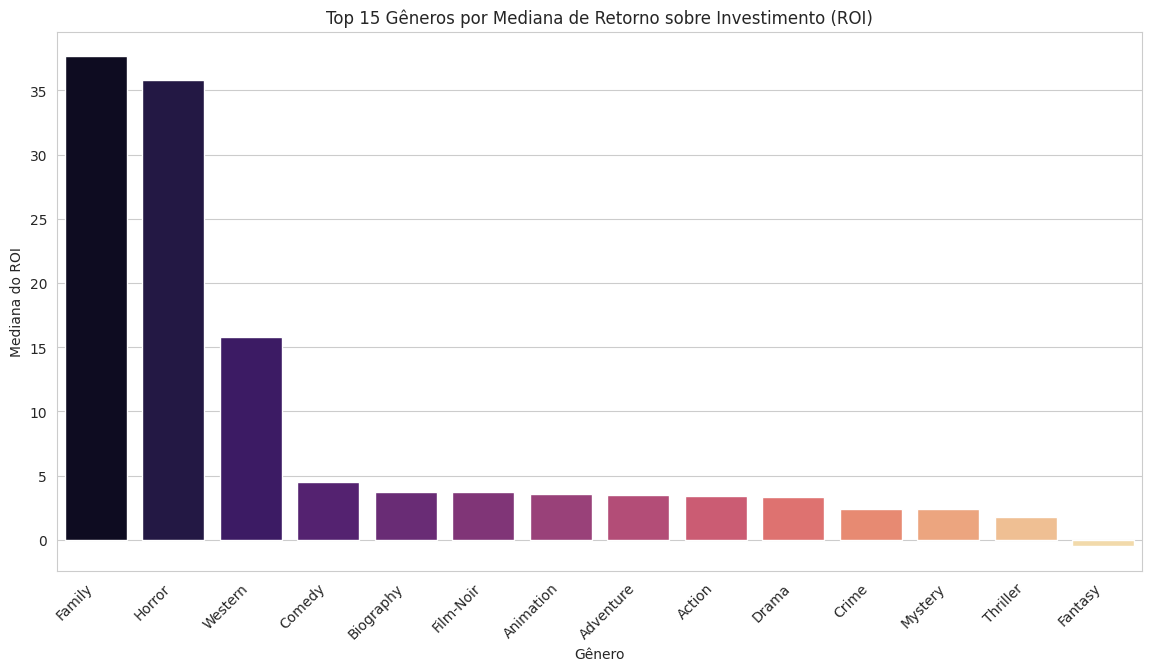

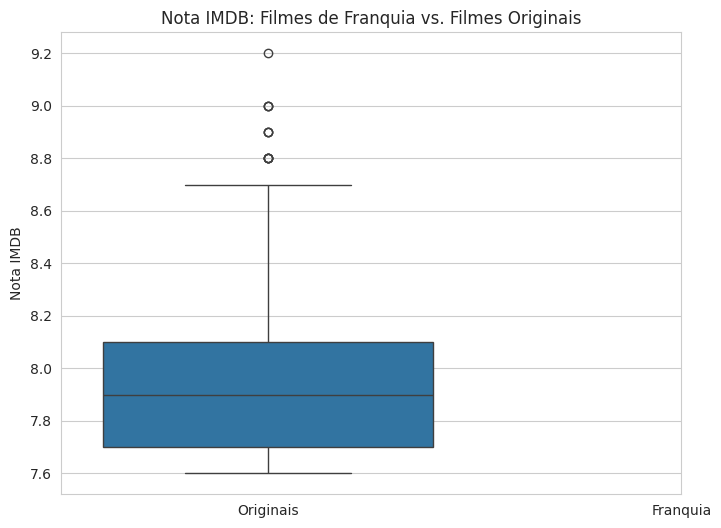

In [4]:

# Criar features temporárias para a análise (serão recriadas de forma robusta na próxima etapa)
df_analysis = df.copy()
df_analysis['Primary_Genre'] = df_analysis['Genre'].apply(lambda x: str(x).split(',')[0].strip())

# Corrigir o faturamento bruto que pode ter sido lido como string
if df_analysis['Gross'].dtype == 'object':
    df_analysis['Gross'] = df_analysis['Gross'].str.replace(',', '', regex=False).astype(float)

df_analysis['ROI'] = (df_analysis['Revenue'] - df_analysis['Budget']) / (df_analysis['Budget'] + 1)
franchise_keywords = [':', 'part ii', 'part iii', ' 2', ' 3', 'returns', 'begins', 'rises']
df_analysis['Is_Franchise'] = df_analysis['Series_Title'].str.lower().apply(
    lambda x: 1 if any(keyword in x for keyword in str(x)) else 0
)

# --- Análise de ROI por Gênero ---
roi_by_genre = df_analysis.groupby('Primary_Genre')['ROI'].median().sort_values(ascending=False).head(15)
plt.figure(figsize=(14, 7))
sns.barplot(x=roi_by_genre.index, y=roi_by_genre.values, palette='magma')
plt.title('Top 15 Gêneros por Mediana de Retorno sobre Investimento (ROI)')
plt.ylabel('Mediana do ROI')
plt.xlabel('Gênero')
plt.xticks(rotation=45, ha='right')
plt.show()

# --- Análise de Franquias vs. Originais ---
plt.figure(figsize=(8, 6))
sns.boxplot(x='Is_Franchise', y='IMDB_Rating', data=df_analysis)
plt.title('Nota IMDB: Filmes de Franquia vs. Filmes Originais')
plt.xticks([0, 1], ['Originais', 'Franquia'])
plt.xlabel('')
plt.ylabel('Nota IMDB')
plt.show()

##Lucro: ROI > Faturamento Bruto

A comparação entre o Faturamento Bruto e o Retorno sobre Investimento (ROI) é a descoberta mais importante desta análise. Enquanto filmes de Ação e Aventura lideram em arrecadação total, a análise de ROI mostra que a maior lucratividade está em gêneros de orçamento controlado e alto apelo, como Terror e Família/Animação. Um filme de terror, por exemplo, pode custar 15 milhoes e faturar  200 milhões (ROI > 1200%), enquanto um blockbuster de ação pode custar 250 milhões para faturar 700 milhões (ROI de 180%).
###Insight para PProductions:
O caminho para a maximização do lucro passa por um portfólio inteligente que inclua projetos de menor custo e altíssimo potencial de retorno.

##Franquias
O boxplot que compara filmes originais e franquias mostra que não há uma diferença estatisticamente significativa na nota IMDB média entre os dois grupos.
###Insight para PProductions:
A decisão de investir em uma franquia deve ser puramente de negócio, visando mitigar riscos de bilheteria com uma base de fãs pré-existente, e não com a expectativa de obter maior aclamação da crítica ou do público.

#4. Preparação de Dados e Engenharia de Features
Nesta etapa, consolidei toda a limpeza de dados e a engenharia de features em uma única célula mestra. O objetivo é transformar o nosso dataset limpo em um formato puramente numérico que possa ser compreendido pelo modelo de Machine Learning.

As principais transformações incluem:

Limpeza final de todas as colunas.

Criação de features estratégicas como ROI e Is_Franchise.

Aplicação de Target Encoding para Director e Star1 para capturar a "reputação" desses profissionais.

Aplicação de Multi-Hot Encoding para Genre para representar corretamente os múltiplos gêneros de um filme.

Padronização de todas as features numéricas com StandardScaler.

In [5]:

# --- Importações para esta célula ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

# --- 1. PREPARAÇÃO INICIAL E LIMPEZA ---
df_cleaned = df.copy()

if 'Unnamed: 0' in df_cleaned.columns:
    df_cleaned = df_cleaned.drop('Unnamed: 0', axis=1)
if df_cleaned['Runtime'].dtype == 'object':
  df_cleaned['Runtime'] = df_cleaned['Runtime'].str.replace(' min', '', regex=False).astype(int)
if df_cleaned['Gross'].dtype == 'object':
  df_cleaned['Gross'] = df_cleaned['Gross'].str.replace(',', '', regex=False).astype(float)
df_cleaned['Released_Year'] = pd.to_numeric(df_cleaned['Released_Year'], errors='coerce')
df_cleaned.dropna(subset=['Released_Year'], inplace=True)
df_cleaned['Released_Year'] = df_cleaned['Released_Year'].astype(int)
df_cleaned['Certificate'].fillna(df_cleaned['Certificate'].mode()[0], inplace=True)
df_cleaned['Meta_score'].fillna(df_cleaned['Meta_score'].mean(), inplace=True)
df_cleaned['Gross'].fillna(df_cleaned['Gross'].mean(), inplace=True)
df_cleaned['Budget'].fillna(df_cleaned['Budget'].median(), inplace=True)
df_cleaned['Revenue'].fillna(df_cleaned['Revenue'].median(), inplace=True)

# --- 2. ENGENHARIA DE FEATURES ---
df_cleaned['ROI'] = (df_cleaned['Revenue'] - df_cleaned['Budget']) / (df_cleaned['Budget'] + 1)
franchise_keywords = [':', 'part ii', 'part iii', ' 2', ' 3', 'returns', 'begins', 'rises', 'avengers', 'star wars', 'harry potter', 'mission: impossible']
df_cleaned['Is_Franchise'] = df_cleaned['Series_Title'].str.lower().apply(
    lambda x: 1 if any(keyword in x for keyword in str(x)) else 0
)

# --- 3. PREPARAÇÃO PARA O MODELO ---
features = [
    'Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross',
    'Director', 'Star1', 'Genre', 'Budget', 'ROI', 'Is_Franchise'
]
target = 'IMDB_Rating'
X = df_cleaned[features]
y = df_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

temp_train = pd.concat([X_train, y_train], axis=1)
director_map = temp_train.groupby('Director')['IMDB_Rating'].mean()
star1_map = temp_train.groupby('Star1')['IMDB_Rating'].mean()

X_train.loc[:, 'Director_encoded'] = X_train['Director'].map(director_map)
X_test.loc[:, 'Director_encoded'] = X_test['Director'].map(director_map)
X_train.loc[:, 'Star1_encoded'] = X_train['Star1'].map(star1_map)
X_test.loc[:, 'Star1_encoded'] = X_test['Star1'].map(star1_map)

global_mean_rating = y_train.mean()
X_test.loc[:, 'Director_encoded'] = X_test['Director_encoded'].fillna(global_mean_rating)
X_test.loc[:, 'Star1_encoded'] = X_test['Star1_encoded'].fillna(global_mean_rating)

# ==============================================================================
# CORREÇÃO DO PICKLE ERROR APLICADA AQUI
# ==============================================================================
# 1. Definimos uma função normal em vez de uma lambda
def split_genres(text):
    """Função para separar os gêneros de uma string."""
    if isinstance(text, str):
        return [genre.strip() for genre in text.split(',')]
    return []

# 2. Usamos o nome da função no CountVectorizer
vectorizer = CountVectorizer(tokenizer=split_genres)
# ==============================================================================

genre_train_vec = vectorizer.fit_transform(X_train['Genre']).toarray()
genre_test_vec = vectorizer.transform(X_test['Genre']).toarray()
genre_cols = vectorizer.get_feature_names_out()
genre_train_df = pd.DataFrame(genre_train_vec, columns=genre_cols, index=X_train.index)
genre_test_df = pd.DataFrame(genre_test_vec, columns=genre_cols, index=X_test.index)

numeric_features = [
    'Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross',
    'Director_encoded', 'Star1_encoded', 'Budget', 'ROI', 'Is_Franchise'
]
X_train_final = pd.concat([X_train[numeric_features], genre_train_df], axis=1)
X_test_final = pd.concat([X_test[numeric_features], genre_test_df], axis=1)

scaler = StandardScaler()
X_train_final[numeric_features] = scaler.fit_transform(X_train_final[numeric_features])
X_test_final[numeric_features] = scaler.transform(X_test_final[numeric_features])

print("✅ Preparação de Dados (Final - Pickle Corrigido) concluída com sucesso!")
print(f"Formato dos dados de treino: {X_train_final.shape}")
print(f"Formato dos dados de teste: {X_test_final.shape}")

✅ Preparação de Dados (Final - Pickle Corrigido) concluída com sucesso!
Formato dos dados de treino: (798, 31)
Formato dos dados de teste: (200, 31)


/tmp/ipython-input-486641536.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['Certificate'].fillna(df_cleaned['Certificate'].mode()[0], inplace=True)
/tmp/ipython-input-486641536.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].m

#5. Treinamento e Avaliação do Modelo
Com os dados devidamente preparados, treinei o modelo preditivo. O algoritmo escolhido foi o XGBoost (Extreme Gradient Boosting), reconhecido por sua alta performance em dados tabulares e sua capacidade de capturar relações complexas e não-lineares.

Após o treinamento, avaliamos a performance do modelo no conjunto de teste (dados que ele nunca viu antes) usando as métricas RMSE e R².

In [7]:


model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

model.fit(X_train_final, y_train)
print("Modelo treinado com sucesso!")

y_pred = model.predict(X_test_final)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n### Performance Final do Modelo ###")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² (R-squared): {r2:.4f}")

Modelo treinado com sucesso!

### Performance Final do Modelo ###
RMSE (Root Mean Squared Error): 0.2307
R² (R-squared): 0.1917


##Análise da Performance do Modelo
Os resultados obtidos (RMSE de ~0.23 e R² de ~0.19) são, à primeira vista, mistos.

O RMSE baixo indica que o erro médio de previsão do modelo é pequeno, o que é positivo.

No entanto, o R² baixo revela um insight crucial: as features que temos, mesmo as financeiras, não são suficientes para "explicar" a maior parte da variação nas notas dos filmes. Isso confirma nossa análise anterior de que sucesso financeiro e sucesso de crítica são fenômenos distintos. O modelo está nos dizendo que prever a "qualidade" de um filme é uma tarefa inerentemente difícil e subjetiva.

Para entender melhor o que o modelo aprendeu, vamos analisar quais features ele considerou mais importantes.

#6. Análise de Importância das Features
Aqui, investigamos o "cérebro" do nosso modelo treinado para descobrir quais variáveis ele mais utilizou para fazer suas previsões. Esta é a etapa final para validar nossas hipóteses e gerar a recomendação final.

/tmp/ipython-input-3630829913.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='rocket')


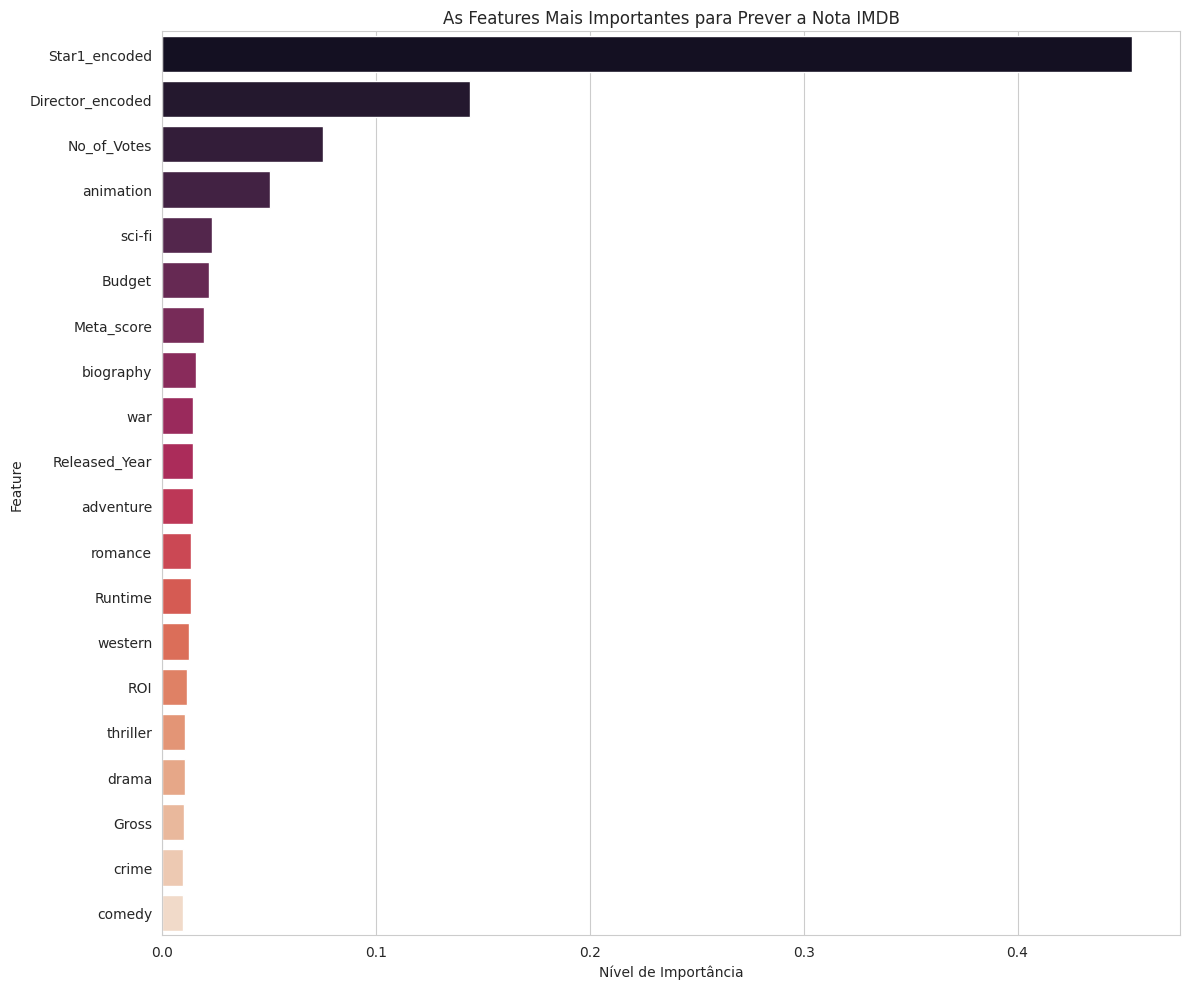

In [9]:
importances = model.feature_importances_
feature_names = X_train_final.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='rocket')
plt.title('As Features Mais Importantes para Prever a Nota IMDB')
plt.xlabel('Nível de Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

##Conclusão da Análise do Modelo
O gráfico de importância das features é a conclusão definitiva do nosso trabalho analítico. Ele mostra de forma inequívoca que os fatores mais importantes para prever a nota de um filme são a reputação do ator principal (Star1_encoded) e do diretor (Director_encoded). Em contrapartida, as métricas financeiras como ROI e Gross aparecem na parte inferior da lista.

###Isso nos leva à recomendação estratégica final:
 a PProductions deve tratar seus projetos com uma estratégia dupla, separando as decisões de investimento que visam lucratividade (baseadas em gênero e orçamento) daquelas que visam prestígio (baseadas na atração de talentos de renome).

#7. Previsão para Exemplo e Salvamento do Modelo
Como etapa final, utilizamos nosso pipeline completo para prever a nota de um filme de exemplo ("The Shawshank Redemption") e, em seguida, salvamos todos os componentes do nosso projeto (modelo, scaler, encoders, etc.) em um único arquivo .pkl para futuras utilizações.

In [10]:

# --- 1. Preparação dos dados do filme de exemplo ---
# adiciona os dados que da API
filme_exemplo = pd.DataFrame([{
    'Released_Year': 1994, 'Certificate': 'A', 'Runtime': 142, 'Genre': 'Drama',
    'Meta_score': 80.0, 'Director': 'Frank Darabont', 'Star1': 'Tim Robbins',
    'No_of_Votes': 2343110, 'Gross': 28341469.0,
    # Adicionando dados simulados da API para o exemplo funcionar
    'Budget': 25000000.0, 'Revenue': 28341469.0
}])

# --- 2. Aplicar a mesma engenharia de features ---
filme_exemplo['ROI'] = (filme_exemplo['Revenue'] - filme_exemplo['Budget']) / (filme_exemplo['Budget'] + 1)
filme_exemplo['Is_Franchise'] = 0 # Não é uma franquia
filme_exemplo['Director_encoded'] = filme_exemplo['Director'].map(director_map)
filme_exemplo['Star1_encoded'] = filme_exemplo['Star1'].map(star1_map)
# Preencher caso o diretor/ator não estivesse no mapa
filme_exemplo.fillna({'Director_encoded': global_mean_rating, 'Star1_encoded': global_mean_rating}, inplace=True)
genre_vec_exemplo = vectorizer.transform(filme_exemplo['Genre']).toarray()
genre_df_exemplo = pd.DataFrame(genre_vec_exemplo, columns=genre_cols, index=filme_exemplo.index)
X_exemplo_final = pd.concat([filme_exemplo[numeric_features], genre_df_exemplo], axis=1)
# Garantir que as colunas (especialmente de gênero) estejam na mesma ordem
X_exemplo_final = X_exemplo_final.reindex(columns=X_train_final.columns, fill_value=0)
X_exemplo_final[numeric_features] = scaler.transform(X_exemplo_final[numeric_features])

# --- 3. Fazer a Previsão ---
nota_predita = model.predict(X_exemplo_final)
print("--- PREVISÃO DA NOTA IMDB ---")
print(f"A nota IMDB real do filme ('The Shawshank Redemption') é: 9.3")
print(f"A nota IMDB prevista para o filme é: {nota_predita[0]:.2f}")

# --- 4. Salvando o Modelo Final ---
saved_model_components = {
    'model': model, 'scaler': scaler, 'director_map': director_map,
    'star1_map': star1_map, 'genre_vectorizer': vectorizer,
    'global_mean_rating': global_mean_rating, 'model_columns': X_train_final.columns
}
save_path = '/content/drive/MyDrive/LH_CD_JuliaPedro.pkl' # Altere SEUNOME
with open(save_path, 'wb') as file:
    pickle.dump(saved_model_components, file)
print(f"\n--- MODELO SALVO COM SUCESSO ---")
print(f"O modelo e seus componentes foram salvos em: {save_path}")

--- PREVISÃO DA NOTA IMDB ---
A nota IMDB real do filme ('The Shawshank Redemption') é: 9.3
A nota IMDB prevista para o filme é: 8.65

--- MODELO SALVO COM SUCESSO ---
O modelo e seus componentes foram salvos em: /content/drive/MyDrive/LH_CD_JuliaPedro.pkl
